# Traffic accidents in France (2018)

---

This notebook serves as report for the Data Mining module of the Nantes Universiy Master Degree of Computing Science.

Made by Loic Lasherme and Louis Boursier on april 30, 2020.

---

1. Data introduction
2. Data preparation part I
    1. Feature selection
    2. Data type checking
    3. Variable creation
3. Exploratory data analysis & Descriptive statistics
    1. Univariate analysis (variable's value distribution)
    2. Bivariate analysis (variable dependence)
4. Data preparation part II
    1. Missing and erroneous values
        1. Method A: Statistically impute values
        2. Method B: Discretize numeric variables
    2. Outliers
    3. Variable Transformation
        1. Standardization
        2. Normalization
5. Models

## 1. Data Introduction

The dataset has been found on [the french government official website](https://www.data.gouv.fr/fr/datasets/base-de-donnees-accidents-corporels-de-la-circulation/). It is called *Base de données accidents corporels de la circulation* which means Traffic Accident Injury Database. It comes from the French Ministry of the Interior and is under **open licence** [which means we can do whatever we want with it as long as we cite the author of the data](https://www.etalab.gouv.fr/wp-content/uploads/2014/05/Licence_Ouverte.pdf). 

For this project, we will focus on the 2018 dataset. 5 files will be used:
* [Description des bases de données ... de 2005 à 2018](https://www.data.gouv.fr/fr/datasets/r/8d4df329-bbbb-434c-9f1f-596d78ad529f) PDF file that describes the meaning of each variable in the files below
* [vehicules-2018.csv](https://www.data.gouv.fr/fr/datasets/r/b4aaeede-1a80-4d76-8f97-543dad479167) Information about the type of vehicle, the damage it took and the maneuver
* [usagers-2018.csv](https://www.data.gouv.fr/fr/datasets/r/72b251e1-d5e1-4c46-a1c2-c65f1b26549a) Information about the driver, passenger, pedestrian... (age, gender...) and the severity of the accident (unharmed, injured, killed...)
* [lieux-2018.csv](https://www.data.gouv.fr/fr/datasets/r/d9d65ca1-16a3-4ea3-b7c8-2412c92b69d9) Information about road infrastructure
* [caracteristiques-2018.csv](https://www.data.gouv.fr/fr/datasets/r/6eee0852-cbd7-447e-bd70-37c433029405) Information about the date, place, weather and collision type

Each CSV file is linked to the others thanks to the numeric variable *Num_ACC* (meaning accident id).

We are interested in the **grav** categorical variable contained in the *lieux2018.csv* file. This variable tells us about the severity of the accident. It can take four different values:

* **1** (unharmed)
* **2** (killed)
* **3** (hospitalied)
* **4** (minor injury)

It seems that this is an ordinal variable as there is an order in the severity of the accident (from unharmed to kill), but the values do not correspond to this order and present the variable as a nominal one. Anyway, for this project, we will binarize this variable into either **unharmed** (0) or **killed** (1) and use it as the class we try to predict.


## 2. Data preparation part I

### A. Feature selection

First of all, we can start with joining the 4 tables on the Num_ACC variable, and then delete this variable as it it just an artifical variable (a key) that is not related to the class we try to predict. We can then discard variables we are sure have no influence on the class (killed or unharmmed). We need to be really carefull when doing so as the relevance of some variable might not be immediatly obvious. Because we are alone on this project, we will take the road traffic expert hat and choose which variables we need and which we can eliminate.

In [1]:
import pandas as pd

peoples = pd.read_csv("Original/usagers-2018.csv", encoding='latin-1')
vehicles = pd.read_csv("Original/vehicules-2018.csv", encoding='latin-1')
locations = pd.read_csv("Original/lieux-2018.csv", encoding='latin-1')
roads = pd.read_csv("Original/caracteristiques-2018.csv", encoding='latin-1')

C:\Users\loutouk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


When loading the file *lieux-2018.csv*, pandas triggers a warning: 

**DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False**

The feature **catr** has mixed types. We will use this information later.

Moreover, when loading the file *caracteristiques-2018.csv* gives us the following error: 

**UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 10: invalid continuation byte**

If we look the encoding of the file using Libre Office Calc, we see that the encoding is set to **latin-1**, this is where the error stems from. Specifiying the encoding to pandas will solve the problem.

In [2]:
# merge all files together on the 'Num_Acc' key
df = pd.merge(peoples, vehicles, on=['Num_Acc','Num_Acc'])
df = pd.merge(df, locations, on=['Num_Acc','Num_Acc'])
df = pd.merge(df, roads, on=['Num_Acc','Num_Acc'])

# remove the 'Num_Acc' key
df = df.drop(['Num_Acc'], 1)

We can now remove variables we are think are not needed:
* **an** We can remove the year because it is always 2018
* **jour** We can remove the day **number** as we do no think it is related to the class (might have been if it was the day name)
* **com** Same (region)
* **adr** Same (person's address)
* **gps** Same
* **lat** Same
* **long** Same
* **v1** We can remove it as it is almost empty and might bias our model
* **v2** We can remove it as it is almost empty and might bias our model
* **lartpc** We can remove it as it is almost empty and might bias our model
* **larrout** We can remove it as it is almost empty and might bias our model
* **vosp** We can remove it (existence of a walking or cycling path nearby) as we do no think it is related to the class
* **pr** We can remove it as it is almost empty and might bias our model
* **pr1** Same
* **locp** Same
* **actp** Same
* **etatp** Same
* **num_veh** Same (licence plate)
* **senc** Same (running direction)

We allowed ourselves to remove those variables as we play the role of the domain expert. However, when we are not sure about which variable we should keep, the choice should be guided by a pragmatic method. Such methods will be explain below.

In [3]:
df = df.drop(['locp','actp','etatp','lartpc','larrout','an','jour','com','adr','gps','lat','long','v1','v2','vosp','pr','pr1','num_veh_x','num_veh_y','senc'], 1)

In [4]:
df.shape

(248406, 31)

We now have 31 variables for 248 406 rows, this is a lot and can be an obstacle for building good models. Irrelevant features can negatively impact model performance, but so will deleting meaningful features. If we want to remove more features
while maintening good model performance, following methods can be used:

* Wrapper methods (multiple models evaluation)
    * Recursive feature elimination
    * ...
* Filter methods (statistical measures)
    * Numerical Input - Numerical Output
        * Pearson’s correlation coefficient (linear)
        * Spearman’s rank coefficient (nonlinear)
    * Numerical Input - Categorical Output
        * ANOVA correlation coefficient (linear)
        * Kendall’s rank coefficient (nonlinear)
    * Categorical Input - Numerical Output
        * Reversed above methods
    * Categorical Input - Categorical Output
        * Chi-Squared test (contingency tables)
        * Mutual Information (works on all types)
* Embedded methods (while the model is learning)
    * Regularization
        * Ridge Regression
        * LASSO
        * ...
    
We want to reduce the number of variables for the following reasons:
* Reduce the data needed to create a good performing model (less exploration needed)
* Less time and energy spent running the algorithm
* Reduce noise and random structures which **seem** to make sense but can foster overfitting

### B. Data type checking

We saw that the feature **catr** had mixed types. Let us start from here. If we read the data description PDF file, we see that this variable can take 7 values:

* **1** Highway
* **2** National road
* **3** County Road
* **4** Local road
* **5** Private road
* **6** Parking lot open to public traffic
* **9** Other

In [5]:
df['catr'].describe()
boxplot = df.boxplot(column=['catr']) # inspects values range with a box lot

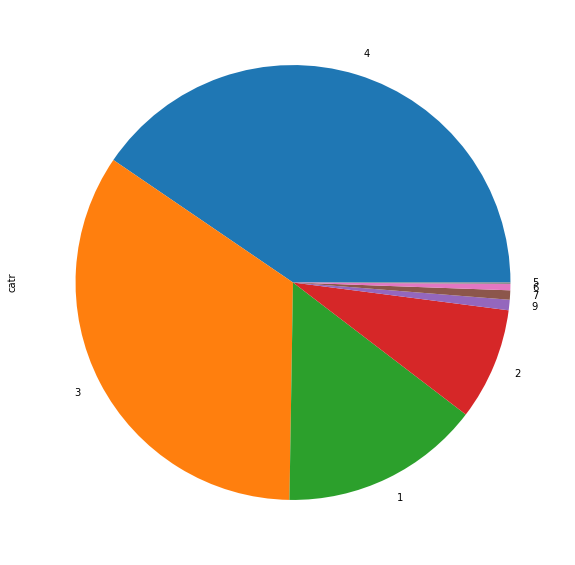

In [6]:
# checks that values match the variable description
# we can see that there exist rows whose catr value is 7 and that should not be according to the data description!
df.catr.value_counts().plot(kind='pie', figsize=(10, 10))

In [7]:
df.loc[df['catr'] == 7.0]

,place,catu,grav,sexe,trajet,secu,an_nais,catv,occutc,obs,...,situ,env1,mois,hrmn,lum,agg,int,atm,col,dep
3478,1.0,1,4,1,1.0,21.0,1975.0,1,0,0.0,...,1.0,0.0,2,745,2,2,6,1.0,3.0,440
3479,1.0,1,4,1,1.0,21.0,1975.0,7,0,0.0,...,1.0,0.0,2,745,2,2,6,1.0,3.0,440
3480,1.0,1,1,2,1.0,11.0,1963.0,1,0,0.0,...,1.0,0.0,2,745,2,2,6,1.0,3.0,440
3481,1.0,1,1,2,1.0,11.0,1963.0,7,0,0.0,...,1.0,0.0,2,745,2,2,6,1.0,3.0,440
3492,1.0,1,3,1,5.0,21.0,1993.0,30,0,0.0,...,1.0,0.0,6,630,5,2,1,1.0,7.0,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208555,1.0,1,4,2,0.0,21.0,1999.0,1,0,0.0,...,3.0,0.0,12,1220,1,2,1,2.0,2.0,690
208590,1.0,1,4,1,0.0,21.0,1997.0,30,0,0.0,...,3.0,0.0,12,1555,1,2,1,8.0,2.0,690
208591,1.0,1,4,1,0.0,21.0,1997.0,7,0,0.0,...,3.0,0.0,12,1555,1,2,1,8.0,2.0,690
208592,1.0,1,1,1,5.0,11.0,1971.0,30,0,0.0,...,3.0,0.0,12,1555,1,2,1,8.0,2.0,690


We discovered that 1721 rows over 248 406 contain the value 7 for the attribute **catr**, which does not correspond to anything according to the data description. For now, we decide to not do any modification as it should probably not impair the model. Another possibility would be to delete the rows (we can consider it as it is les than 2% of the total dataset) or to impute values with statistical tools.

Using the command ```df.dtypes```, we can see pandas loaded some categorical variables as numbers (int64 or float64)  instead of string (object). This is understandable as the values of those categorical variables often are numerical. **We should cast them back to string, otherwise the model could be biased into *thinking* there is an order in some variable**, where there is actually not. This could also lead the model into attributing more importance to the bigger values than the smaller. 

We see that there is almost only categorical variables, this is a bad thing for models working only whith number. Indeed, operation like one hot encoding to translate categorical variable to numerical one will generate more variable that will add up to the existing 31. Fortunately, we can still do feature selection as mentioned above, and dimensionality reduction (at the cost of not being able to make sense of the input anymore).

Returning to the previous problem, the presence of the value 7 for the catr feature will translate into a kind of *NULL* category and will not be a problem anymore. A bit like we could handle empty values.

In [8]:
df.dtypes # tells us the type for each column

place      float64
catu         int64
grav         int64
sexe         int64
trajet     float64
secu       float64
an_nais    float64
catv         int64
occutc       int64
obs        float64
obsm       float64
choc       float64
manv       float64
catr         int64
voie        object
circ       float64
nbv        float64
prof       float64
plan       float64
surf       float64
infra      float64
situ       float64
env1       float64
mois         int64
hrmn         int64
lum          int64
agg          int64
int          int64
atm        float64
col        float64
dep          int64
dtype: object

In [9]:
# cast categorical variables to string
df['place'] = df['place'].astype(str)
df['catu'] = df['catu'].astype(str)
df['grav'] = df['grav'].astype(str)
df['sexe'] = df['catu'].astype(str)
df['trajet'] = df['trajet'].astype(str)
df['secu'] = df['secu'].astype(str)
df['catv'] = df['catv'].astype(str)
df['obs'] = df['obs'].astype(str)
df['obsm'] = df['obsm'].astype(str)
df['choc'] = df['choc'].astype(str)
df['manv'] = df['manv'].astype(str)
df['catr'] = df['catr'].astype(str)
df['voie'] = df['voie'].astype(str)
df['circ'] = df['circ'].astype(str)
df['prof'] = df['prof'].astype(str)
df['plan'] = df['plan'].astype(str)
df['surf'] = df['surf'].astype(str)
df['infra'] = df['infra'].astype(str)
df['situ'] = df['situ'].astype(str)
df['env1'] = df['env1'].astype(str)
df['mois'] = df['mois'].astype(str)
df['lum'] = df['lum'].astype(str)
df['agg'] = df['agg'].astype(str)
df['int'] = df['int'].astype(str)
df['atm'] = df['atm'].astype(str)
df['col'] = df['col'].astype(str)
df['dep'] = df['dep'].astype(str)

In [10]:
# identifies which columns have many different values
columns = list(df)
for i in columns: 
    if df[i].value_counts().size > 10:
        print (i + " " + str(df[i].value_counts().size))

secu 19
an_nais 104
catv 24
occutc 79
obs 18
choc 11
manv 26
voie 1535
nbv 14
surf 11
mois 12
hrmn 1362
dep 101


We can leverage our human potential to alleviate the algorithms from some of their work. A first step could be to iterate over all columns, and inspect categorical variables that exceed a limit in the size of the number of values they harbor. 

By doing so, we discovered that the **secu** variable contains 19 different possibilities. Reading the documentation to understand why it is so, we saw that this variable is actually the concatenation of two different variables. The first part can take (5+1) different values and (3+1) for the second, leading to potentially 24 different combinations!
If we read the description, the first part is about the presence of a security equipment such as a belt or a helmet, and the second is about the whether this equipment was used or not. 
**We need to find a way to reduce the combinations.** A solution can be to only pay attention to the belt:
* **11** belt is fastened
* **12** belt is not fastened
* **0**  set all remaining combinations to zero

In [11]:
for index, row in df.iterrows():
    if row.secu != '11.0' and row.secu != '12.0':
        df.at[index,'secu'] = '0.0'

We now have reduced the **secu** distinct values count from 19 to 3 without, hopefully, altering the quality of the future models. 

We can do the same analysis for the other variables. The next one is **catv** which is about the kind of vehicle involved. Reading the data description, we can see that some values are not used. We can easily set them all to a shared value used for the *NULL* or *OTHER* type. In this case, it is the value 99. For the remaining values, we can group common vehicles with the same id. For exemple, we can set small moped and scooter to the same value.

In [12]:
for index, row in df.iterrows():
    if row.catv == '02': # group by small motorcycle
        df.at[index,'catv'] = '30'
    if row.catv == '31': # group by medium motorcycle
        df.at[index,'catv'] = '32'
    if row.catv == '33': # group by big motorcycle
        df.at[index,'catv'] = '34'
    if row.catv == '38': # group by bus
        df.at[index,'catv'] = '37'
    if row.catv == '04' or row.catv == '05' or row.catv == '06' or row.catv == '08' \
        or row.catv == '09' or row.catv == '18' or row.catv == '19': # group by null or other
        df.at[index,'catv'] = '99'

count     248406
unique        21
top            7
freq      162465
Name: catv, dtype: object

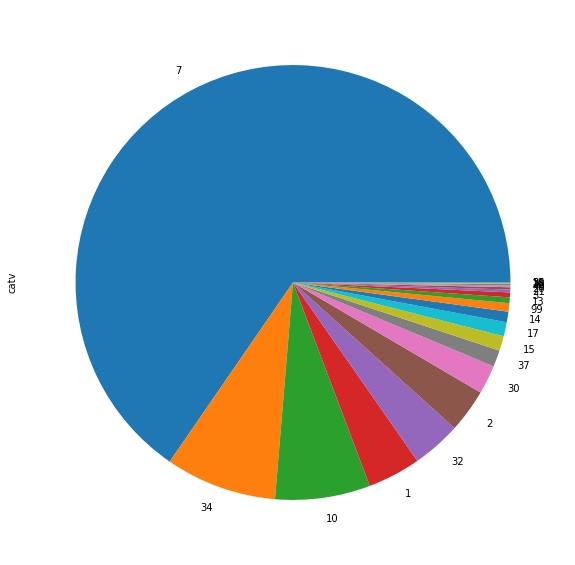

In [13]:
df.catv.value_counts().plot(kind='pie', figsize=(10, 10))
df['catv'].describe()

We see that most of the data is about the **07** vehicle type. It translates into *light vehicle* and means the everyday car.
If future models reveal themselves too complex (and have bad performance), we could always restrict ourselves to this type of vehicle. We could also generalize even more to group some vehicles into the same category. We also need to be aware that **future models can have trouble to predict correctly the class for vehicles that are not the *07* type**, because this vehicle type is ubiquitous and the model will be incentivize to predict correctly for this type of vehicle with less care for other vehicle types. Indeed, focusing on the most represented type will generate the best score on average.

The same kind of reasoning can be applied to those variables:
* obs
* choc
* manv


Following up, the **voie** variable (road id) has more than a thousand possible values. This is huge and it seems reasonable to think model will struggle to cope with that. Hence the suppresion. Same thing for the **dep** variable (region).

In [14]:
df = df.drop(['voie'], 1)
df = df.drop(['dep'], 1)

### C. Variable creation
The class variable will be produced from the **grav** variable. As said before, **we will set it to 1 if the severity of the accident is lethal (value=2) and to 0 otherwise (value=1,3,4)**. We will then drop the grav variable.

Plotting the value counts of the grav variable, we see that **lethal accidents are underrepresented** (which makes sense as most of the accidents are not lethal). As explained before, **this can reduce the precision of the model when it will have to predict a positive class (lethal)**. We can either let the algorithm do the work by itself (but help it by choosing an appropriate scoring method and prioritize confusion matrix over accuracy), or help it by resampling, i.e. making the training set have an equal representation of lethal and non lethal accidents.

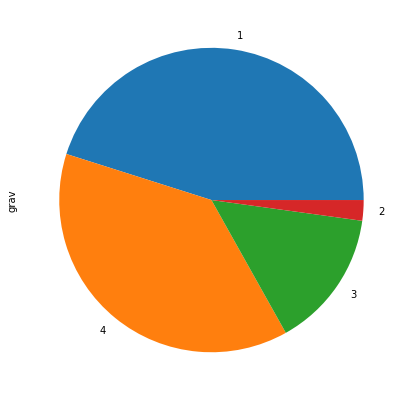

In [15]:
df.grav.value_counts().plot(kind='pie', figsize=(7, 7))

In [16]:
def generateClass (row):
    if row['grav'] == '1' or row['grav'] == '4' or row['grav'] == '3':
        return 0 # non lethal
    return 1 # lethal

# create new column for class variable and attach it to the frame
# axis=1 specifier means that the application is done at a row rather than a column level
df['lethal'] = df.apply(lambda row: generateClass(row), axis=1) 

# drop the grav variable
df = df.drop(['grav'], 1)

df['lethal'].describe()

count    248406.000000
mean          0.021791
std           0.146001
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: lethal, dtype: float64

## 3. Exploratory data analysis & Descriptive statistics

### 1. Univariate analysis (variable's value distribution)

In this part, we will explore variable one by one. We have to keep in mind that only looking at one variable at a time might not give us enough insight to understand the dataset and relation between variables. This is where Bivariate (and multivariate) analysis come to the rescue.


The method differs whether the variable is catgeorical or numerical. We have a lot of variables and most of them are categorical. We will not make a thorough analysis on each, but categorical variable can be easily explored with a pie chart.

We can explore the value range of a numeric variable with these tools:

| Tool | Visualization |
| :-:  | :-: |
| central value| box plot |
| dispersion| histogram |

**The first one to consider is the shape**, because the other indicators will only make sense on unimodal distribution (one single peak). Computing the mean or the variance without looking at the data distribution can be misleading. Many choices of indicator pairs exist to explore the distribution:

|   -  | Central value | Dispersion | Drawback | Advantage |
| :-:  | :-: | :-: | :-: | :-: |
| Choice A | mode | interquartile range | unstable | - |
| Choice B | median | range | few properties | robust to extreme values & good for asymmetrical distribution |
| Choice C| mean | variance | sensible to extreme values | many properties & often used |

Let us plot our numerical variables and see if it makes sense to compute their mean and variance.

In [17]:
df.dtypes # which variables are categorical and which are numerical?

place       object
catu        object
sexe        object
trajet      object
secu        object
an_nais    float64
catv        object
occutc       int64
obs         object
obsm        object
choc        object
manv        object
catr        object
circ        object
nbv        float64
prof        object
plan        object
surf        object
infra       object
situ        object
env1        object
mois        object
hrmn         int64
lum         object
agg         object
int         object
atm         object
col         object
lethal       int64
dtype: object

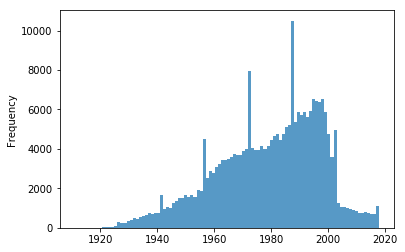

In [18]:
df.an_nais.plot.hist(bins=100, alpha=0.75) # uses many bins to have a precise look at the distribution (birth year)

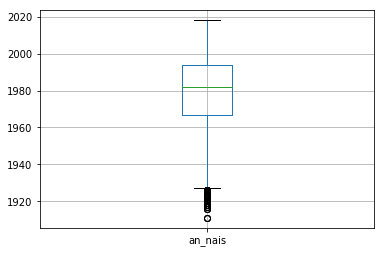

In [19]:
df.boxplot(column=['an_nais']) # birth year

In [20]:
df["an_nais"].describe()
#df["an_nais"].var()
#df["an_nais"].median()

count    248352.000000
mean       1979.360299
std          18.271537
min        1911.000000
25%        1967.000000
50%        1982.000000
75%        1994.000000
max        2018.000000
Name: an_nais, dtype: float64

From the histogram plot perspective, the data distribution looks **unimodal** (though there exist some methods to rigorously check that), so it makes sense to compute the mean and the variance. The mean is 1979 (41 years old in 2020). **The distribution is asymmetrical, with a negative skew (points go to the negative direction on the left).** This explains why the mean and the median are slightly different. Indeed, it makes sense that the mean is lower than the median in a negatively skewed dataset (respectively 1979 and 1982).

**When a variable is significantly skewed, it may not be suited for statistical analysis**. This is why we may need to transform its value later on to make it compatible with algorithms using such statistics. An example would be to standardize this variable to make it suited for k-means. 

The variance is 333. Another way to look at the variance is to look at the standard deviation (square root of the variance). It is roughly 18. We can also look at the histogram plot: the spreader it is, the higher the standard deviation is.

As a rule of thumb, we can compute the coefficient of variation (CV) to make sense of standard deviation:

CV = deviation/mean

CV = 18.27.../(2018-1979.36...)

CV = 0.46...

CV < 1

So we can consider it a low standard variation: individuals are relatively close to the mean, age speaking.


The same goes for the other numeric variables.

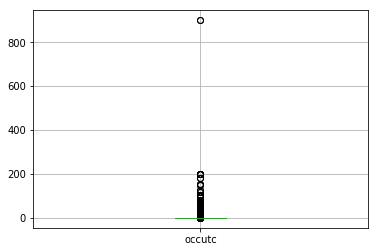

In [21]:
df.boxplot(column=['occutc']) # number of people in the public transit vehicle

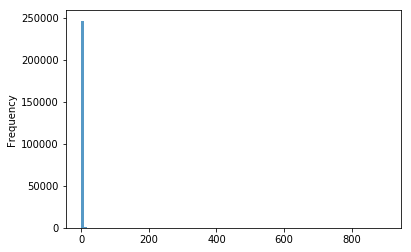

In [22]:
df.occutc.plot.hist(bins=100, alpha=0.75) # number of people in the public transit vehicle

In [23]:
df['occutc'].describe() # number of people in the public transit vehicle
df.occutc.value_counts() # number of people in the public transit vehicle

0      245366
1         879
10        193
50        135
2         133
        ...  
39          2
59          2
48          2
180         2
120         2
Name: occutc, Length: 79, dtype: int64

Here we have an extreme example of an unbalanced data distribution. What happens is that most of the accidents do not concern public transit. So **occutc** values 0. But when it does concern public transit, this number is high due to the very nature of public transit. We will have to address the uneven distribution later. We can also question the usefulness of this variable.

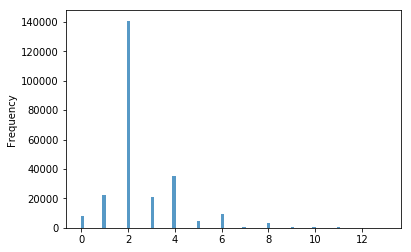

In [24]:
df.nbv.plot.hist(bins=100, alpha=0.75) # number of lanes on the road

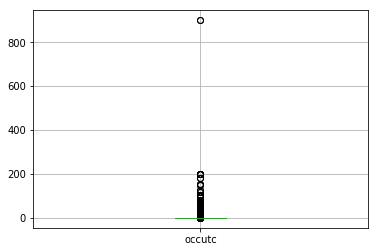

In [25]:
df.boxplot(column=['occutc']) # number of lanes on the road

In [26]:
df['occutc'].describe() # number of lanes on the road

count    248406.000000
mean          0.243291
std           4.211869
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         900.000000
Name: occutc, dtype: float64

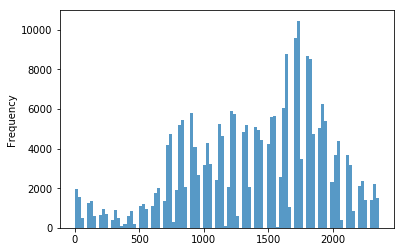

In [27]:
df.hrmn.plot.hist(bins=100, alpha=0.75) # time of the accident on 24 hours (hoursminutes)

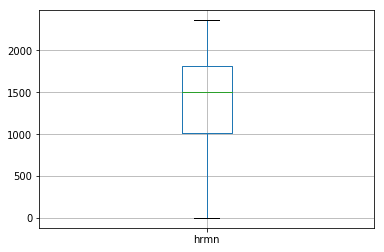

In [28]:
df.boxplot(column=['hrmn']) # time of the accident on 24 hours (hoursminutes)

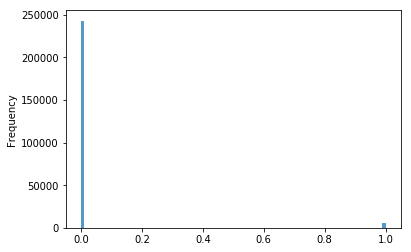

In [29]:
df.lethal.plot.hist(bins=100, alpha=0.75) # lethality of the accident (the class we will try to predict)

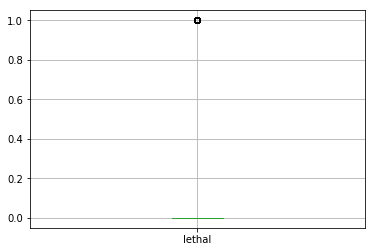

In [30]:
df.boxplot(column=['lethal']) # lethality of the accident (the class we will try to predict)

**As seen before, the lethal accidents are underrepresented, and this can negatively impact future models**.

### 2. Bivariate analysis (variable dependence)

This step is crucial, **because identifying that the relation between a predictor variable and the target variable is linear would allow us to use a simple linear model to make a class prediction. On the contrary, nonlinear relationship would require us to use a non-linear model to get the best performance**. Anyway, it is recommended to start with a simple linear model first and only jump to a more complex or nonlinear one if it does not yield sufficient results.

We also talked about how we should try to remove predictor variable that are not correlated to the target variable. Univariate analysis can be naive for this purpose. The fact that the univariate correlation between a predictor variable and the target variable is low does not necessarily mean this predictor variable is useless: a predictor variable combined with other predictor variables could have a significant correlation with the target variable.

Also, detecting correlation in between predictor variables means that a simpler (better) model with fewer feature can exist. This is where we could use dimensionality reduction like PCA or Autoencoders, or feature selection like RFE.

In [31]:
#we can start by visualizing relationships between numerical variables
#but in our our case it does not really make sense to compare those variables are they do not seem related
#from pandas.plotting import scatter_matrix
#import matplotlib.pyplot as plt
#numericVariables = pd.DataFrame(df,columns=['an_nais','occutc','nbv','hrmn','lethal'])
#numericVariables = pd.DataFrame(df,columns=['an_nais','occutc','nbv'])
#scatter_matrix(numericVariables, figsize=(10,10))
#plt.show()

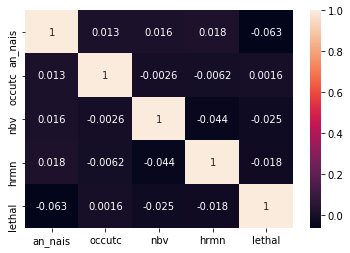

In [32]:
import seaborn as sn
import matplotlib.pyplot as plt

# we can then confirm our hypothesis using statistic tools

numericVariables = pd.DataFrame(df,columns=['an_nais','occutc','nbv','hrmn','lethal'])
corrMatrix = numericVariables.corr(method='pearson') # linear relationships

sn.heatmap(corrMatrix, annot=True)
plt.show()

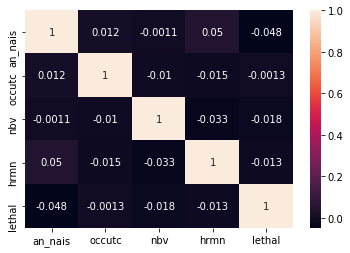

In [33]:
numericVariables = pd.DataFrame(df,columns=['an_nais','occutc','nbv','hrmn','lethal'])
corrMatrix = numericVariables.corr(method='spearman') # monotonic relationships

sn.heatmap(corrMatrix, annot=True)
plt.show()

It seems that there is no strong bivariate relationship between our numeric variables. 

Let us examine relationships between categorical predictor variables and the target variable.

**We will show only the most interesting variables, i.e. the ones that are correlated with death during an accident.**

In [34]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import numpy as np

# must pass data to a contingency table first

# lighting conditions
crosstab = pd.crosstab(df['lum'], df['lethal']) 
print(crosstab)
stat, p, dof, expected = chi2_contingency(crosstab)
# we can reject the null hypothesis if the p-value is less than 0.05, and say there is no correlation

lethal       0     1
lum                 
1       166991  3274
2        15907   383
3        23208  1289
4         2126    53
5        34761   414


The null hypothesis put aside, we can see something really interesting when diving into the contingency table. It may not be obvious as the categorical variable is nominal and unordered. But if we have a look a the data description, we can try to make it an ordinal variable. The **lum** variable is about the road lighting. **If we compute the ratios of the number of death by accidents for each type of light condition, we see that the darker it is, the deadliest the accidents are.**

As to why there is less death at night whith lighting, the reason may be that those condtions appear in a city environment, where the speed is restricted so collisions are less violent.

* MORE LETHAL
* 3 (at night without public lighting) &rarr; 18
* 4 (at night with public lighting unlit) &rarr; 40
* 2 (dusk or dawn) &rarr; 41
* 1 (daylight) &rarr; 51
* 5 (at night with public lighting lit) &rarr; 84
* LESS LETHAL



In [35]:
# was the belt (11) fastened or not(12)?
crosstab = pd.crosstab(df['secu'], df['lethal'])
print(crosstab)
stat, p, dof, expected = chi2_contingency(crosstab)

lethal       0     1
secu                
0.0      82615  2983
11.0    158140  2155
12.0      2238   275


**Not wearing a seatbelt is correlated with a 10 times higher risk of death in an accident!**

In [36]:
# type of vehicle
crosstab = pd.crosstab(df['catv'], df['lethal'])
stat, p, dof, expected = chi2_contingency(crosstab)
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

1: 50.0
10: 57.0
13: 37.0
14: 15.0
15: 15.0
16: 29.0
17: 15.0
2: 64.0
20: 22.0
21: 10.0
3: 24.0
30: 147.0
32: 75.0
34: 33.0
35: 52.0
36: 24.0
37: 67.0
39: 4.0
40: 79.0
7: 48.0
99: 61.0


**Vehicle type ordered by death per accident ratio:**


1. Train
2. Farm tractor
3. Vehicle weighing more than 7.5T OR more than 3.5T with a trailer OR tractor with trailer

On the contrary, small scooter (motor < 50cm3) are the less correlated with death. But for motorbike, the bigger the engine is, the deadliest the outcome of the accident is.

**It does not mean that train transportation is unsafe, but that accidents involving trains are the most correlated with death**.

In [37]:
# obstacle hit
crosstab = pd.crosstab(df['obs'], df['lethal'])
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

0.0: 54.0
1.0: 51.0
10.0: 28.0
11.0: 21.0
12.0: 25.0
13.0: 13.0
14.0: 42.0
15.0: 17.0
16.0: 17.0
2.0: 7.0
3.0: 20.0
4.0: 43.0
5.0: 14.0
6.0: 14.0
7.0: 19.0
8.0: 14.0
9.0: 47.0
nan: 40.0


***Beware of the trees***

In [38]:
# whether the person is a driver (1), passenger (2), or pedestrian (3)
crosstab = pd.crosstab(df['catu'], df['lethal'])
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

1: 46.0
2: 55.0
3: 19.0


In [39]:
# was the accident out of the city (1) or in the city (2)
crosstab = pd.crosstab(df['agg'], df['lethal'])
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

1: 25.0
2: 102.0


In [40]:
crosstab = pd.crosstab(df['int'], df['lethal']) # the place where the accident happend
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

1: 38.0
2: 79.0
3: 66.0
4: 70.0
5: 55.0
6: 76.0
7: 187.0
8: 7.0
9: 65.0


**Interesting: the zebra crossing (8) is the most correlated with death. And previously, we saw that pedestrian are also more correlated with death. Zebra crossing involves pedestrian, so it seems that those variables are dependant.**

In [41]:
crosstab = pd.crosstab(df['choc'], df['lethal']) # the type of collision
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

0.0: 34.0
1.0: 38.0
2.0: 44.0
3.0: 37.0
4.0: 144.0
5.0: 83.0
6.0: 71.0
7.0: 44.0
8.0: 47.0
9.0: 21.0
nan: 46.0


**Not surprisingly, multiple impacts and car rollovers (9) are the most correlated with death**.
Rear end collisions are the less deadly.

In [42]:
crosstab = pd.crosstab(df['manv'], df['lethal']) # the type of maneuver
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

0.0: 40.0
1.0: 36.0
10.0: 62.0
11.0: 75.0
12.0: 151.0
13.0: 17.0
14.0: 20.0
15.0: 83.0
16.0: 100.0
17.0: 43.0
18.0: 83.0
19.0: 45.0
2.0: 113.0
20.0: 163.0
21.0: 40.0
22.0: 300.0
23.0: 111.0
24.0: 65.0
3.0: 123.0
4.0: 43.0
5.0: 25.0
6.0: 20.0
7.0: 454.0
8.0: 228.0
9.0: 117.0
nan: 47.0


**in order: Driving away on left (13) and right (14), then crossing the central reservation (6) and driving the wrong way (5) are the most correlated with death.**

In [43]:
crosstab = pd.crosstab(df['circ'], df['lethal']) # the type of road traffic
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

0.0: 76.0
1.0: 119.0
2.0: 33.0
3.0: 70.0
4.0: 110.0
nan: 65.0


**As we might expect, two-way roads are more correlated with death**.

In [44]:
crosstab = pd.crosstab(df['plan'], df['lethal']) # the road layout
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

0.0: 129.0
1.0: 53.0
2.0: 25.0
3.0: 23.0
4.0: 31.0
nan: 51.0


**The road layout (*plan* variable) is interesting. Curves (2,3,4) look two times more deadly than a straight line (1)**. We can binarize this variable to make it easier for future models.

In [45]:
# binarize into a curve or not a curve
for index, row in df.iterrows():
    if row.plan == '2.0' or row.plan == '3.0': # curve
        df.at[index,'plan'] = '4.0'

In [46]:
# check the result
crosstab = pd.crosstab(df['plan'], df['lethal']) # the road layout
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

0.0: 129.0
1.0: 53.0
4.0: 25.0
nan: 51.0


In [47]:
crosstab = pd.crosstab(df['surf'], df['lethal']) # the road layout
for i in range(len(crosstab[0])): # print ratios
    print(str(crosstab[0].index.values[i]) + ": " + str(round(crosstab[0][i]/crosstab[1][i],0)))

0.0: 103.0
1.0: 45.0
2.0: 45.0
3.0: 52.0
4.0: 29.0
5.0: 38.0
6.0: 23.0
7.0: 19.0
8.0: 34.0
9.0: 24.0
nan: 55.0


---

After having performed a bivariate analysis on each variable, we have more intel on which variables might be useless. But this might be misleading, as there may be more complex relationshipsthat only multivariate analysis would reveal. Anyway, we will not do that here.

Some predictor variables are removed because it seems they are not related to the target variable:

* mois (month)
* sexe (gender)
* hrmn (time of the accident)
* env1 (school nearby)
* prof (road profile)
* surf (the road condition)

Some variables are removed because it seems they are correlated to other predictor variables and they do not give more information than we we already have:

* obsm (mobile obstacle hit, correlated to the person and the place of the accident)
* occutc (number of people in the vehicle, correlated to the type of vehicle)
* nbv (number of lanes, correlated to the type of road)

In [48]:
df = df.drop(['mois'], 1)
df = df.drop(['sexe'], 1)
df = df.drop(['hrmn'], 1)
df = df.drop(['env1'], 1)
df = df.drop(['prof'], 1)
df = df.drop(['surf'], 1)
df = df.drop(['obsm'], 1)
df = df.drop(['occutc'], 1)
df = df.drop(['nbv'], 1)

## 4. Data preparation part II

### A. Missing and erroneous values

There are two kind of bad values we have to deal with:

* Wrong values -> We hope to have detected and corrected them all in the exploratory analysis
* Missing values -> We have to transform them because many algorithms can't work with them (linear regression, k-means...)

**We can also delete the rows (or variables) for which such values appear, but this is not recommended and the total number of deleted rows must be less than 2% of the total rows in the data set.**

#### A.1. Method A: Statistically impute values (replace with a correct value)

One way to do that is to use simple or multiple imputation:

* Simple imputation
    * Replace with the mean or the mode (not good)
    * Clustering and above method in each cluster (good)
    * Generate a predictive model like random forest, KNN or multiple linear regresion (good)
 
Simple imputation artificially reduces the diversity of the data. A solution is to introduce randomness with mutliple imputation. 
>The random component is important so that all missing values of a single variable are not all exactly equal. One example would be to use a regression equation to predict missing values, then add a random error term.

* [Multiple imputation](https://www.theanalysisfactor.com/multiple-imputation-in-a-nutshell)

>Multiple imputation is used to generate multiple datasets, perform statistical analysis on them, and average the results. Multiple imputation takes a simple imputation and adds to it a random value to try to restore randomness lost in the imputation process. Therefore, averaging multiple imputations before doing any statistical analysis on them just removes most of that restored randomness (by averaging) and gives a result close to simple imputation plus a small random error.

#### A.2. Method B: Discretize numeric variables (if this a numeric variable)

This is another option, but we will not use it in this project.

___

##### *The snake biting its tail.*

For simplicity, we will use simple imputation to predict missing values. **The problem is that standard models for predicting missing values do not handle missing or *nan* values.** 



So what we can do is make a temporary simpler model than does not contain missing or *nan* values and use it to predict those missing values.





In [49]:
df.shape

(248406, 20)

In [50]:
# we start by looking for missing values
# categorical missing values are 'nan' and numerical missing values are nan
# note that some missing values might not be revealed with this method

tempDf = df.dropna() # drops numeric nan
tempDf = tempDf[(tempDf!='nan').all(1)] # drops string nan
tempDf.shape

C:\Users\loutouk\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


(233925, 20)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# place variable is the one with the most missing values (10 000 +)
# we will make a model to impute its missing values
# all others represent less than 2% of the dataset and will be dropped

X = tempDf.drop('place', axis=1)
y = tempDf['place']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [52]:
tempDf['place'].value_counts() # the value distribution could use resampling but we will manage without it

1.0    188647
2.0     28404
3.0      4895
4.0      4120
9.0      2716
7.0      2453
8.0      1259
5.0      1100
6.0       331
Name: place, dtype: int64

Precision:	0.38978998533124787
Recall:		0.29941780946709895
F-measure:	0.3098827546050357


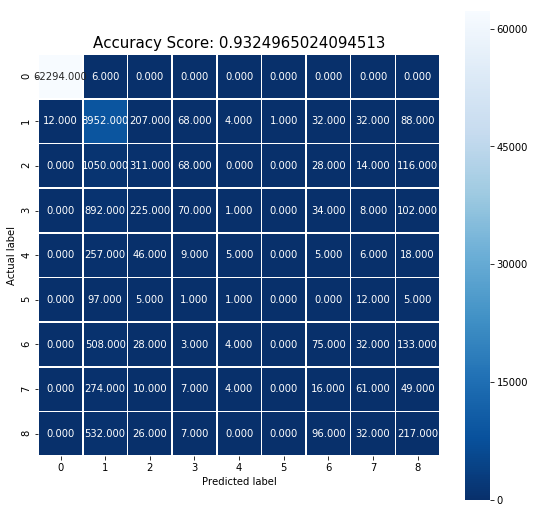

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support

# try to make predictions with a decision tree

# there are tools to find optimal hyperparameters such as grid search
# but those are overkill as this is only an intermediate step, we will not use that right now
clf = DecisionTreeClassifier(max_depth=8) # set a max depth to reduce overfiting
clf = clf.fit(X_train, y_train)

y_true = np.array(y_test)
y_pred = np.array(clf.predict(X_test))

# we are interested with the macro parameter, because we want to check precision and recall
# this is because the value distribution for y is unbalanced and we have not done some resampling
# we want to have good precision and recall but avoid overfitting: need to find the optimal parameters

# macro: calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
scores = precision_recall_fscore_support(y_true, y_pred, average='macro')
print('Precision:\t' + str(scores[0]))
print('Recall:\t\t' + str(scores[1]))
print('F-measure:\t' + str(scores[2])) 

score = clf.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, clf.predict(X_test))

plt.figure(figsize=(9,9))
sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

After evaluating several models, it looks like decision tree classifier is the best one. As we said, we looked carefully at the confusion matrix, precision and recall because the unbalanced distribution in the variable's values incentivize the algorithm to output the most common value to have a better accuracy on average. Actually, because all this is done to impute value to a predictor variable, only accuracy really matters here. We just want to impute the good value **on average**.

**It will be different when we will try to predict the target variable (is it a lethal accident?), we will trade accuracy for recall.** [We can compare it as cancer prediction: this is a **critical** and **sensible** prediction where we want to reduce false negatives](https://medium.com/techspace-usict/measuring-just-accuracy-is-not-enough-in-machine-learning-a-better-technique-is-required-e7199ac36856).

* Precision: How much our model correctly classifies positives cases out of all actual positive cases
* Recall: How much the model correctly predicts the positive cases out of the cases which the model predicts positive
* F1-Score: A balance between precision and recall

>Imagine that you made a model that always predicts cancer negative no matter what example you are gonna throw to it. This is a dangerous scenario because a patient with cancer will always gets prediction of not having a cancer with an accuracy of 90%.




Now that we have a model to impute values for the place variable, we are going to use it on our main data frame. Doing so, we will have a complete data frame without missing values so much needed for future models that can not run with missing values. But first, we need to remove missing values from other variables in order for our current model to work on each row. We can do that and bypass the process of creating a predictor model for each other variables containing missing values as they represent roughly less than 2% of the total data set.

In [54]:
df['place'].value_counts() # many 'nan' valuest = df

1.0    191111
2.0     28839
nan     11349
3.0      4955
4.0      4161
9.0      2756
7.0      2505
8.0      1273
5.0      1121
6.0       336
Name: place, dtype: int64

In [55]:
# remove all missing values except for the place column
# for this column, there are too many missing values so we chose to impute them with a classifier
# this is because removing too many rows/records could hurt future model learning

df = df[df.an_nais.notna()] # numeric
df = df[df.trajet != 'nan'] # string
df = df[df.plan != 'nan']
df = df[df.infra != 'nan']
df = df[df.situ != 'nan']
df = df[df.circ != 'nan']
df = df[df.atm != 'nan']
df = df[df.col != 'nan']
df = df[df.obs != 'nan']
df = df[df.choc != 'nan']
df = df[df.manv != 'nan']

# iterate over all rows and impute place value when it is missing
for index, row in df.iterrows():
    if row.place == 'nan':
        x = np.array(row[1:]) # remove the target variable
        reshaped_to_2d = np.reshape(x, (-1, len(x))) # cast 1D into 2D as required 
        prediction = clf.predict(reshaped_to_2d)[0] # fetch the prediction
        df.at[index,'place'] = prediction # impute the predicted value to our main dataframe

In [56]:
df['place'].value_counts() # no more 'nan' values

1.0    188647
2.0     38527
3.0      5104
4.0      4542
9.0      2865
7.0      2494
8.0      1485
5.0      1109
6.0       331
Name: place, dtype: int64

### B. Outliers

Outliers can have a dramatic impact on a model's performance. Especially those computing distances or expecting gaussian value distribution like logistic or linear regression. If their impact are too strong, we can delte or replace those values. How to replace them?

* [Winsorize the variable](https://en.wikipedia.org/wiki/Winsorizing)

>  A typical strategy is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile.

* Discretize the variable

We choose the winsorizing method to deal with the last numeric variable *an_nais* (birth year).

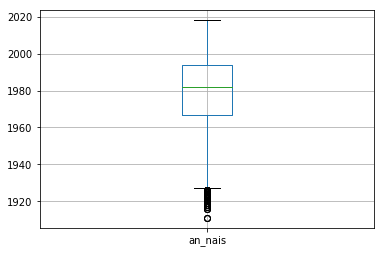

In [57]:
boxplot = df.boxplot(column=['an_nais']) # look for outliers

In [58]:
from scipy.stats.mstats import winsorize
# limits is the percentages to cut on each side of the array
winsorized = winsorize(df['an_nais'], limits=(0.01,0.01))
temp = pd.DataFrame(data=winsorized)

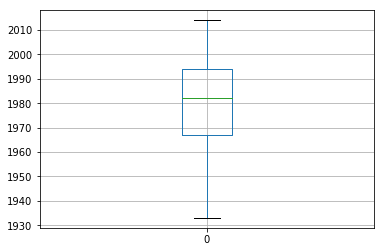

In [59]:
boxplot = temp.boxplot(column=[0]) # no more outliers

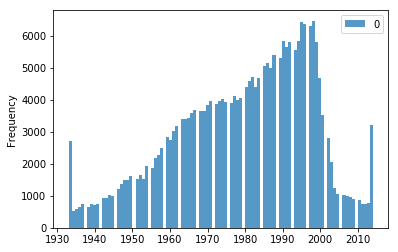

In [60]:
temp.plot.hist(bins=100, alpha=0.75) # check the data distribution

We notice a problem: winsorizing our variable changed its shape. It was unimodal but it is now multimodal (3 peaks). This is because there was not really any outsiders, and winsorizing pushed left and right end values so that they are packed together. This is not what we want, so we will not apply this change to our main data frame.

### C. Variable Transformation

We saw the the value distribution of *an_nais* has a negative skewness. This might be a problem for some algorithms.

#### Standardization

This is needed before using an algorithm computing distances (K-means, Factor analysis like multiple correspondence analysis...). This allows for different variables to have the same weight in the analysis and neutralize the scale diffference between them.

####  Normalization

The goal is to transform a variable so that it tends to have a gaussian distribution. It is usefull for algorithms that suppose a gaussian distribution, like linear regression. The idea is to apply a mathematical transformation:

* For positive skewness: Y^2 or Y^3
* For negative skewness: log(Y) or log(1+Y) or sqrt(Y)
* For percentages between 0 and 1: arcsin(sqrtY))


####  Discretize

The goal is to split a numeric value into different intervals. If we have not acces to a domain expert, the best way to do that is to use gaussian mixture model. Discretizing has the following advantages:

* can consider non linear relationships between variables
* can increase model performance (robust)
* can neutralize the effect of missing values and outliers

___

We want to normalize the *an_nais* variable to solve the skewness problem before feeding the data to a linear regression model.

In [61]:
df['an_nais']

0         1928.0
1         1928.0
2         1960.0
3         1960.0
4         1947.0
           ...  
248401    1974.0
248402    1973.0
248403    1973.0
248404    1990.0
248405    1990.0
Name: an_nais, Length: 245104, dtype: float64

In [62]:
normalized = np.log10((df['an_nais']-df['an_nais'].min()+1))

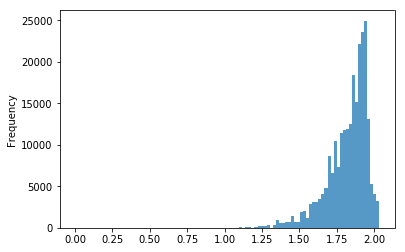

In [63]:
normalized.plot.hist(bins=100, alpha=0.75) # check

In [64]:
df['an_nais'] = normalized # apply transformation

## 5. Models

### A. Linear regression

We will use scikit-learn to predict the class variable. Scikit-learn does not handle very well categorical variables, so we have to start with applying a multiple correspondence analysis (MCA) to transform categoric variables to numeric variables (we do not touch to the target variable and keep intact in the main dataframe). This is a PCA for categorical variables. The first step is to do a one hot encoding with *pandas.get_dummies()*.

MCA is originally meant for dimensionality reduction, but in our case, we subvert it for numeric casting.
So we can take advantage of the MCA to do dimensionality reduction, but it is not mandatory if we do not want to lose information. The model can handle to proceed all information by it itself.

Why do not we just do one hot encoding?
* Because we would end up with a lot of variables
* And it is harder to make a prediction model in a high dimension space
* And dummy variables often values 0 and are useless

On the contrary, MCA produces intelligent variables as it highlights most important ones:
* First axis contains the most information (variance)
* Second axis contains the most information amongst orthogonal axis to 1
* And so on...

Running the MCA triggers a MemoryError (even on Python3 64 bits). There is too much data to handle. Let this be the opportunity to do some resampling on the target variable distribution. This will dramatically reduce the number of rows used for the MCA.


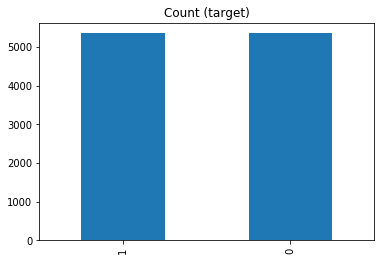

In [65]:
# resampling

# class count
count_class_0, count_class_1 = df.lethal.value_counts()

# divide by class
df_class_0 = df[df['lethal'] == 0]
df_class_1 = df[df['lethal'] == 1]
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
df_test_under.lethal.value_counts().plot(kind='bar', title='Count (target)');

In [66]:
X = df_test_under.drop('lethal', axis=1)
y = df_test_under['lethal']
dfbin=pd.get_dummies(X)

In [67]:
from mca2 import *

dfbin=pd.get_dummies(X)
acm=mca(dfbin)
# we can do dimensionality reduction by precising which percentage of the best variables to keep
compressed=acm.fs_r(percent=0.50)
df_numeric = pd.DataFrame(data=compressed)
df_numeric.shape

(10700, 28)

In [68]:
df_numeric.isna().sum() # check that there are no na left

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
dtype: int64

In [69]:
y.isna().sum() # check that there are no na left

0

In [70]:
from sklearn.model_selection import train_test_split

X = df_numeric
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [71]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(y_test, y_pred))

Coefficients: 
 [-0.23736    -1.67531309  0.33316846 -0.14553412 -0.3336348   0.64808662
 -1.03287724  0.07690473 -0.49957091  0.77159797 -0.48972796 -0.08657016
  0.27033089 -0.18314449  0.49812651 -0.16774232 -0.47858434 -0.15567882
  0.03627608 -0.21010568 -0.19561285  0.20672235  0.09577504 -0.14695871
  0.15291505 -0.27469083  0.16342141 -0.23949098]
Mean squared error: 0.17
Coefficient of determination: 0.30


C:\Users\loutouk\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7434154630416313
{'n_neighbors': 10}
Precision:	0.7441119663061067
Recall:		0.7426043622706919
F-measure:	0.7427091905441776


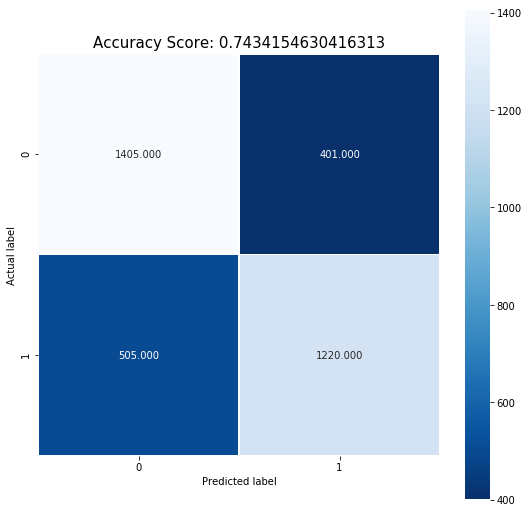

In [77]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# n_neighbors = Number of neighbors to use by default for kneighbors queries.
param_grid={'n_neighbors': range(2,11,2)} # try different hyper parameters and let GridSearchCV pick up the
knn = GridSearchCV(KNeighborsClassifier(), param_grid)

knn.fit(X_train, y_train)
KNeighborsClassifier()

score = knn.score(X_test, y_test) # simple scoring
print(score)
#score = cross_val_score(knn, X, y, cv=5)  # cross validation
#print(score)
print(knn.best_params_) # best param

y_true = np.array(y_test)
y_pred = np.array(knn.predict(X_test))

# macro: calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
scores = precision_recall_fscore_support(y_true, y_pred, average='macro')
print('Precision:\t' + str(scores[0]))
print('Recall:\t\t' + str(scores[1]))
print('F-measure:\t' + str(scores[2])) 

cm = metrics.confusion_matrix(y_test, knn.predict(X_test))
plt.figure(figsize=(9,9))
sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

C:\Users\loutouk\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7312376097422827
{'max_depth': 5}
Precision:	0.7312157801562924
Recall:		0.7313366074437864
F-measure:	0.7311958703756811


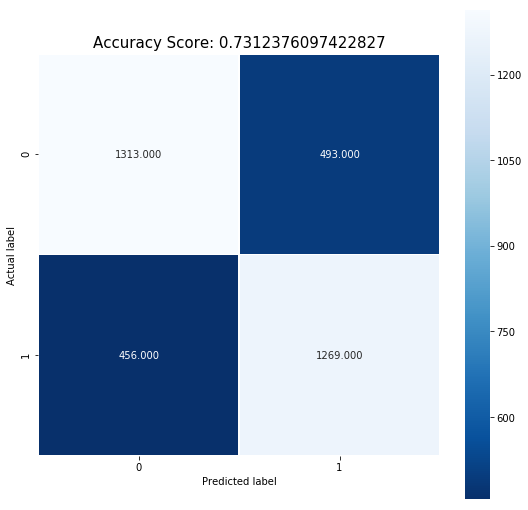

In [78]:
param_grid={'max_depth': range(3,9,1)}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid)
clf = clf.fit(X_train, y_train)

score = clf.score(X_test, y_test) # simple scoring
print(score)

print(clf.best_params_) # best param

y_true = np.array(y_test)
y_pred = np.array(clf.predict(X_test))

# macro: calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
scores = precision_recall_fscore_support(y_true, y_pred, average='macro')
print('Precision:\t' + str(scores[0]))
print('Recall:\t\t' + str(scores[1]))
print('F-measure:\t' + str(scores[2])) 

cm = metrics.confusion_matrix(y_test, clf.predict(X_test))
plt.figure(figsize=(9,9))
sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

C:\Users\loutouk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7496459926366469
Precision:	0.7500024072533432
Recall:		0.7500211854205787
F-measure:	0.7496458119184289


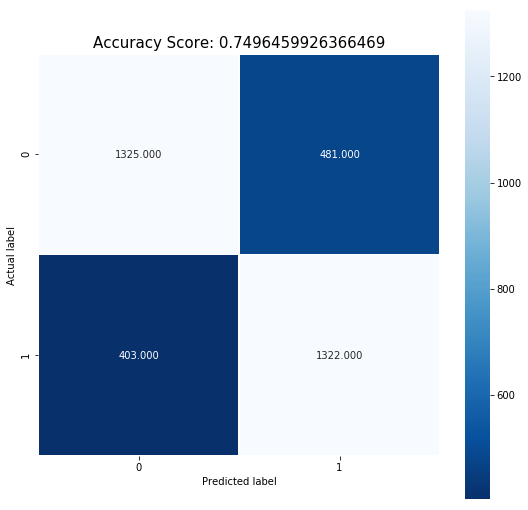

In [75]:
from sklearn.linear_model import LogisticRegression
logRegr = LogisticRegression()
logRegr.fit(X_train, y_train)


score = logRegr.score(X_test, y_test) # simple scoring
print(score)

y_true = np.array(y_test)
y_pred = np.array(logRegr.predict(X_test))

# macro: calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
scores = precision_recall_fscore_support(y_true, y_pred, average='macro')
print('Precision:\t' + str(scores[0]))
print('Recall:\t\t' + str(scores[1]))
print('F-measure:\t' + str(scores[2])) 

cm = metrics.confusion_matrix(y_test, logRegr.predict(X_test))
plt.figure(figsize=(9,9))
sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

**We can assert how much the model is capable of distinguishing between class using the ROC curve**. We want the biggest area under curve (AUC) which translates into a curve close to the top left corner. On the contrary, the closer the curve comes to the 45 degrees (diagonal), the worst the model can distinguish between classes.

KNN: ROC AUC=0.820
Decision tree: ROC AUC=0.791
Logistic regression: ROC AUC=0.821


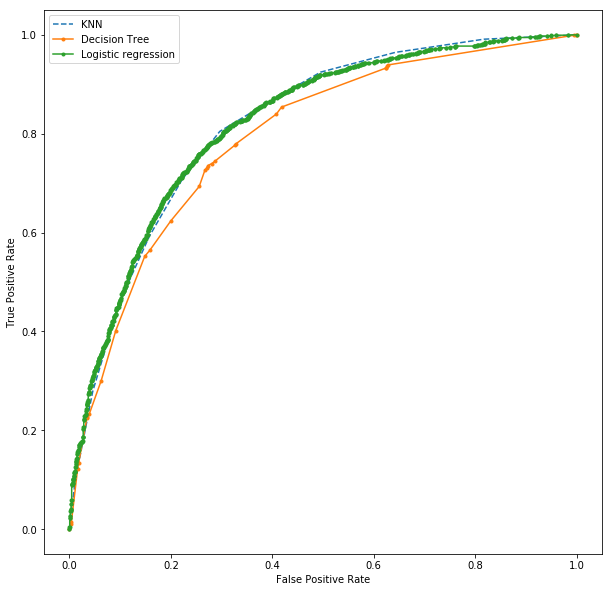

In [79]:
# roc curve and auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

knn_probs = knn.predict_proba(X_test)
clf_probs = clf.predict_proba(X_test)
lr_probs = logRegr.predict_proba(X_test)
# keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]
clf_probs = clf_probs[:, 1]
lr_probs = lr_probs[:, 1]
# calculate scores
knn_auc = roc_auc_score(y_test, knn_probs)
clf_auc = roc_auc_score(y_test, clf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('KNN: ROC AUC=%.3f' % (knn_auc))
print('Decision tree: ROC AUC=%.3f' % (clf_auc))
print('Logistic regression: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
clf_fpr, clf_tpr, _ = roc_curve(y_test, clf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(knn_fpr, knn_tpr, linestyle='--', label='KNN')
pyplot.plot(clf_fpr, clf_tpr, marker='.', label='Decision Tree')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.gcf().set_size_inches(10, 10)
pyplot.show()

We can use the original data frame that did not went through MCA dimensionality reduction to build another decision tree classifier. The interest is that we can make sense of the decision tree and see which predictor variables are the most correlated with the target variable. **We can also take informed decision for safety guidelines. Like increasing lighting at night and make the belt mandatory.**

In [87]:
clf_bis = DecisionTreeClassifier(max_depth=4)

X_bis = df_test_under.drop('lethal', axis=1)
y_bis = df_test_under['lethal']
X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(X_bis, y_bis, test_size=0.30, shuffle=True)
clf_bis = clf_bis.fit(X_train_bis, y_train_bis)

score = clf_bis.score(X_test_bis, y_test_bis)
print(score)

cm = metrics.confusion_matrix(y_test_bis, clf_bis.predict(X_test_bis))
print(cm)

tree_performance = roc_auc_score(y_test_bis, clf_bis.predict_proba(X_test_bis)[:, 1])
print('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))

0.7601246105919003
[[1146  445]
 [ 325 1294]]
DecisionTree: Area under the ROC curve = 0.8168412965301657


In [88]:
from sklearn.tree import export_graphviz
from graphviz import Digraph

dot = Digraph(comment='Tree interpretable')
export_graphviz(clf_bis,out_file='tree_uncompressed.dot', feature_names = X_bis.columns, class_names=['Non-lethal', 'Lethal'], filled=True, )
#visualize the dot file on https://dreampuf.github.io/GraphvizOnline/